Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Greykite Forecast Components Config and Grid Search

* Greykite model components include seasonality, changepoints, events, etc.: https://linkedin.github.io/greykite/docs/0.1.0/html/pages/model_components/0100_introduction.html#model-components
  * Seasonality config: https://linkedin.github.io/greykite/docs/0.1.0/html/pages/model_components/0300_seasonality.html
  * Events config: https://linkedin.github.io/greykite/docs/0.1.0/html/pages/model_components/0400_events.html
  * Cutomized fit algorithm: https://linkedin.github.io/greykite/docs/0.1.0/html/pages/model_components/0600_custom.html
* Greykite grid search reference: https://linkedin.github.io/greykite/docs/0.1.0/html/gallery/quickstart/0500_grid_search.html

In [1]:
import plotly
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import HTML

from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.common.features.timeseries_features import get_available_holidays_across_countries

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_ts(ts, title, exclude_cols):
    %pylab inline
    plt.figure(figsize=(20,3))
    for col in ts.columns:
        if col in exclude_cols:
            continue
        fig = plt.plot(ts[col], label=col)
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [3]:
ts_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df.head()

(942, 1)


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


Populating the interactive namespace from numpy and matplotlib


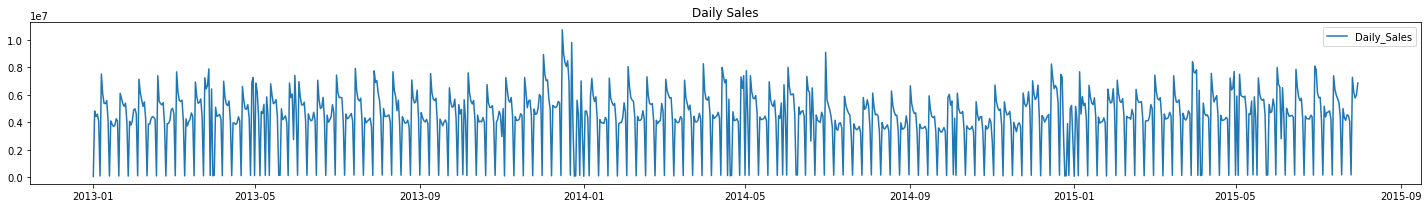

In [4]:
plot_ts(ts_df, title='Daily Sales', exclude_cols=['Date'])

In [5]:
ts_df = ts_df.reset_index()
back_test_period = ts_df.loc[ts_df['Date'] >= '2015-03-01']['Date'].nunique()

print(back_test_period)

153


## Customize Model Components

In [46]:
# print out events strings
holiday_lookup_countries = ['China', 'US', 'Canada']

cross_country_holidays = get_available_holidays_across_countries(
    countries=holiday_lookup_countries,
    year_start=2013,
    year_end=2015)
print(cross_country_holidays)

['Boxing Day', 'Boxing Day (Observed)', 'Canada Day', 'Chinese New Year', 'Christmas Day', 'Civic Holiday', 'Columbus Day', 'Dragon Boat Festival', 'Easter Monday', 'Family Day', 'Good Friday', 'Independence Day', 'Independence Day (Observed)', 'Labor Day', 'Labour Day', 'Martin Luther King Jr. Day', 'Memorial Day', 'Mid-Autumn Festival', 'National Day', "New Year's Day", 'Thanksgiving', 'Tomb-Sweeping Day', 'Veterans Day', 'Victoria Day', "Washington's Birthday"]


### Silverkite Template

In [47]:
seasonality = dict(
     yearly_seasonality = "auto",
     quarterly_seasonality = [False, True], 
     monthly_seasonality = [2, 3],  # the value means # of weeks here, and the value can't be more than 4 since there are at most 4 weeks in a month
     weekly_seasonality = [True, False],
     daily_seasonality = False
)

events = dict(
    holidays_to_model_separately = ['Christmas Day', "New Year's Day", "Easter Monday", "Labour Day", "Labor Day"],
    holiday_lookup_countries = ['China', 'US', 'Canada'],
    holiday_pre_num_days=2,
    holiday_post_num_days=2,
)

custom = {
     "fit_algorithm_dict": [
         {"fit_algorithm": "ridge"},
         {"fit_algorithm": "gradient_boosting"},
         {"fit_algorithm": "rf"}
     ]
}


model_components = ModelComponentsParam(
     seasonality=seasonality,
     events=events,
     custom=custom
)

evaluation_period = EvaluationPeriodParam(
     test_horizon=back_test_period,  # # of days as testing data
     cv_horizon=back_test_period,  # # of days in CV validation data
     cv_max_splits=5,              # 5 folds CV
     cv_min_train_periods=back_test_period*3  # min # of days in CV training data
 )

metadata = MetadataParam(
     time_col="Date",
     value_col="Daily_Sales",
     freq="D"
)

config = ForecastConfig(
    model_template=ModelTemplateEnum.SILVERKITE.name,
    metadata_param=metadata,
    forecast_horizon=back_test_period,  # the number of steps to forecast ahead
    model_components_param=model_components,
    evaluation_period_param=evaluation_period
)

In [48]:
forecaster = Forecaster()  
result = forecaster.run_forecast_config(  
     df=ts_df,
     config=config
)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


#### Cross Validation

In [49]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=2,
     cv_report_metrics=None,  # It saves space in the printed output. Remove to show all available metrics and columns.
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose().T

,rank_test_MAPE,mean_test_MAPE,split_test_MAPE,mean_train_MAPE,split_train_MAPE,mean_fit_time,mean_score_time
params,,,,,,,
"[('estimator__weekly_seasonality', True), ('estimator__quarterly_seasonality', False), ('estimator__monthly_seasonality', 2), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",18,142.79,"(114.57, 171.01)",166.0,"(173.91, 158.09)",12.45,1.16
"[('estimator__weekly_seasonality', False), ('estimator__quarterly_seasonality', False), ('estimator__monthly_seasonality', 2), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",21,160.53,"(144.82, 176.25)",187.54,"(213.64, 161.44)",11.73,1.19
"[('estimator__weekly_seasonality', True), ('estimator__quarterly_seasonality', True), ('estimator__monthly_seasonality', 2), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",20,145.54,"(119.88, 171.2)",161.64,"(166.05, 157.24)",12.03,1.21
"[('estimator__weekly_seasonality', False), ('estimator__quarterly_seasonality', True), ('estimator__monthly_seasonality', 2), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",24,163.92,"(152.28, 175.56)",176.06,"(191.85, 160.28)",11.75,1.09
"[('estimator__weekly_seasonality', True), ('estimator__quarterly_seasonality', False), ('estimator__monthly_seasonality', 3), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",17,142.69,"(114.4, 170.98)",166.03,"(173.69, 158.37)",10.85,0.68
"[('estimator__weekly_seasonality', False), ('estimator__quarterly_seasonality', False), ('estimator__monthly_seasonality', 3), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",22,160.55,"(145.09, 176.01)",187.46,"(213.48, 161.43)",9.23,0.68
"[('estimator__weekly_seasonality', True), ('estimator__quarterly_seasonality', True), ('estimator__monthly_seasonality', 3), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",19,145.15,"(119.72, 170.58)",161.23,"(165.53, 156.93)",10.74,0.73
"[('estimator__weekly_seasonality', False), ('estimator__quarterly_seasonality', True), ('estimator__monthly_seasonality', 3), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'ridge'})]",23,163.7,"(152.14, 175.27)",175.74,"(191.44, 160.04)",11.99,1.26
"[('estimator__weekly_seasonality', True), ('estimator__quarterly_seasonality', False), ('estimator__monthly_seasonality', 2), ('estimator__fit_algorithm_dict', {'fit_algorithm': 'gradient_boosting'})]",10,77.53,"(91.92, 63.13)",51.9,"(48.21, 55.59)",2.82,0.89


#### Backtest

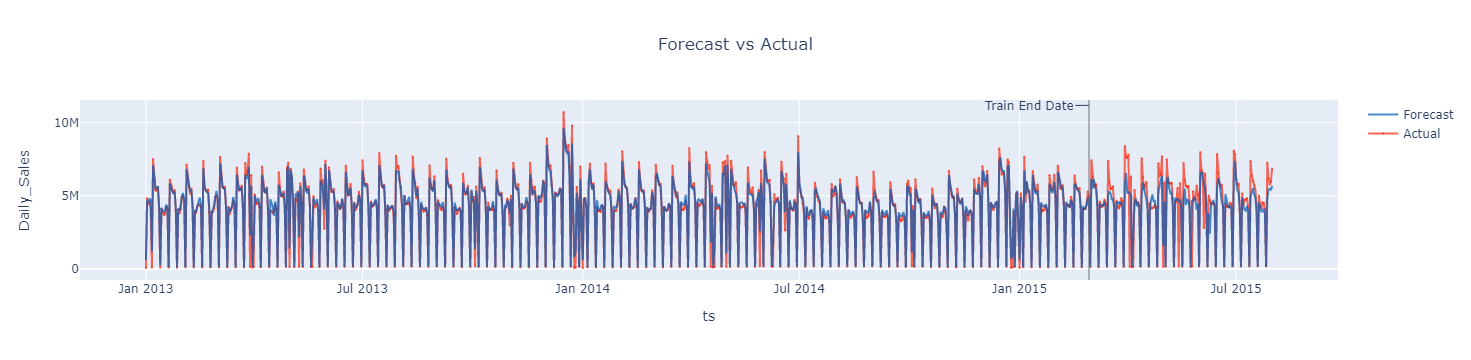

In [50]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [51]:
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
    backtest_eval[metric].append(value)
    backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

,train,test
CORR,0.986988,0.885348
R2,0.970405,0.755517
MSE,132717672435.652008,1259124264713.959961
RMSE,364304.367851,1122107.064729
MAE,213330.459569,678958.019608
MedAE,121816.92,370986.8
MAPE,29.373405,83.087884
MedAPE,2.973471,8.504461
sMAPE,4.058427,8.570081
Q80,105598.552203,438680.431529


#### Forecast

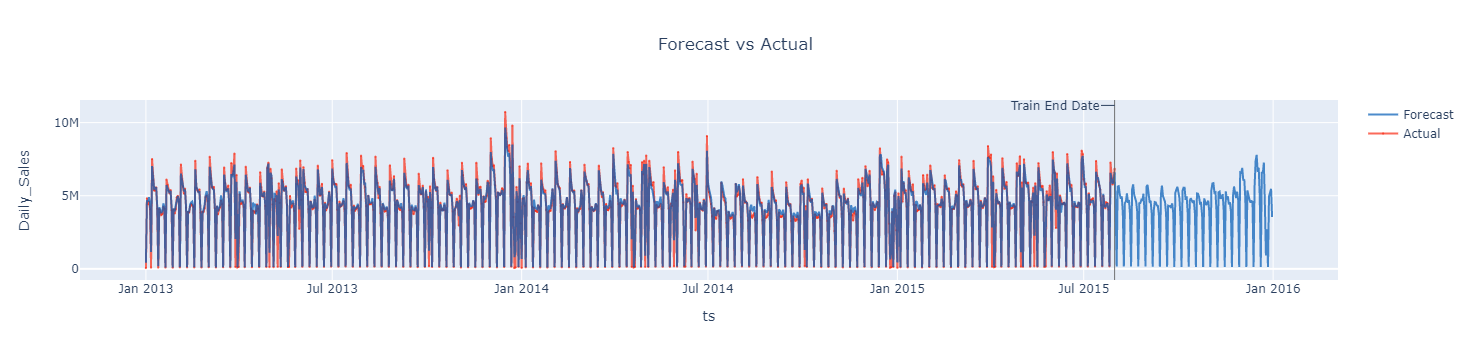

In [52]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

#### Model Summary

In [53]:
summary = result.model[-1].summary()  # -1 retrieves the estimator from the pipeline
print(summary.fit_algorithm, summary.ml_model)

coef_summary_df = summary.info_dict['coef_summary_df']
coef_summary_df = coef_summary_df.sort_values(by='Importance rank')
HTML(coef_summary_df.to_html())

rf RandomForestRegressor()


,Pred_col,Feature importance,Importance rank
36,"C(Q('str_dow'), levels=['1-Mon', '2-Tue', '3-Wed', '4-Thu', '5-Fri', '6-Sat', '7-Sun'])[T.7-Sun]",3.255605e-01,1
44,"C(Q('str_dow'), levels=['1-Mon', '2-Tue', '3-Wed', '4-Thu', '5-Fri', '6-Sat', '7-Sun'])[T.7-Sun]:ct1",2.874118e-01,2
37,ct1,3.555538e-02,3
49,sin1_ct1_yearly,1.716294e-02,4
73,sin13_ct1_yearly,1.685967e-02,5
50,cos1_ct1_yearly,1.642010e-02,6
6,"C(Q('events_Easter Monday'), levels=['', 'event'])[T.event]",1.582376e-02,7
48,cos2_tom_monthly,1.223541e-02,8
72,cos12_ct1_yearly,1.087521e-02,9
11,"C(Q('events_Labor Day'), levels=['', 'event'])[T.event]",1.011513e-02,10


In [54]:
summary.get_coef_summary(is_interaction=True, return_df=True)

         Pred_col Feature importance  Importance rank
   is_weekend:ct1           0.006226               30
str_dow_2-Tue:ct1           0.002513               49
str_dow_3-Wed:ct1           0.001598               51
str_dow_4-Thu:ct1           0.006707               29
str_dow_5-Fri:ct1           0.004174               43
str_dow_6-Sat:ct1           0.007919               19
str_dow_7-Sun:ct1             0.2874                2


,Pred_col,Feature importance,Importance rank,is_intercept,is_time_feature,is_event,is_trend,is_seasonality,is_lag,is_regressor,is_interaction
0,is_weekend:ct1,0.006226,30,0,1,0,1,0,0,0,1
1,str_dow_2-Tue:ct1,0.002513,49,0,1,0,1,0,0,0,1
2,str_dow_3-Wed:ct1,0.001598,51,0,1,0,1,0,0,0,1
3,str_dow_4-Thu:ct1,0.006707,29,0,1,0,1,0,0,0,1
4,str_dow_5-Fri:ct1,0.004174,43,0,1,0,1,0,0,0,1
5,str_dow_6-Sat:ct1,0.007919,19,0,1,0,1,0,0,0,1
6,str_dow_7-Sun:ct1,0.287412,2,0,1,0,1,0,0,0,1


### Prophet Template

In [55]:
seasonality = dict(
     seasonality_mode=["multiplicative", "additive"],
     yearly_seasonality = True,
     weekly_seasonality = [True, False],
     daily_seasonality = False,
     add_seasonality_dict=[
        {
            'monthly': {
                'period': 365.25/12,
                'fourier_order': 2
            },
            'quarterly': {
                'period': 365.25/4,
                'fourier_order': 2
            }
        }]
)

events = dict(
    holiday_lookup_countries = ['China', 'US', 'Canada'],
    holiday_pre_num_days=[2],
    holiday_post_num_days=[2],
)

custom = {
     "fit_algorithm_dict": [
         {"fit_algorithm": "ridge"},
         {"fit_algorithm": "gradient_boosting"},
         {"fit_algorithm": "rf"}
     ]
}


model_components = ModelComponentsParam(
     seasonality=seasonality,
     events=events,
     custom=custom
)

evaluation_period = EvaluationPeriodParam(
     test_horizon=back_test_period,  # # of days as testing data
     cv_horizon=back_test_period,  # # of days in CV validation data
     cv_max_splits=5,              # 5 folds CV
     cv_min_train_periods=back_test_period*3  # min # of days in CV training data
 )

metadata = MetadataParam(
     time_col="Date",
     value_col="Daily_Sales",
     freq="D"
)

prophet_config = ForecastConfig(
    model_template=ModelTemplateEnum.PROPHET.name,
    coverage=0.95,  # this is mandatory for Prophet template
    metadata_param=metadata,
    forecast_horizon=back_test_period, 
    model_components_param=model_components,
    evaluation_period_param=evaluation_period
)

In [56]:
prophet_forecaster = Forecaster()  
prophet_result = prophet_forecaster.run_forecast_config(  
     df=ts_df,
     config=prophet_config
)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


#### Cross Validation

In [57]:
grid_search = prophet_result.grid_search
cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=2,
     cv_report_metrics=None,  # It saves space in the printed output. Remove to show all available metrics and columns.
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose().T

,rank_test_MAPE,mean_test_MAPE,split_test_MAPE,mean_train_MAPE,split_train_MAPE,mean_fit_time,mean_score_time
params,,,,,,,
"[('estimator__weekly_seasonality', True), ('estimator__seasonality_mode', 'multiplicative')]",1,73.36,"(90.91, 55.81)",55.07,"(50.64, 59.51)",4.09,8.04
"[('estimator__weekly_seasonality', False), ('estimator__seasonality_mode', 'multiplicative')]",4,438.51,"(419.89, 457.12)",432.78,"(444.76, 420.8)",3.97,8.58
"[('estimator__weekly_seasonality', True), ('estimator__seasonality_mode', 'additive')]",2,98.56,"(90.73, 106.39)",57.86,"(51.85, 63.87)",2.0,7.55
"[('estimator__weekly_seasonality', False), ('estimator__seasonality_mode', 'additive')]",3,430.31,"(410.27, 450.34)",423.28,"(434.07, 412.49)",3.01,7.09


#### Backtest

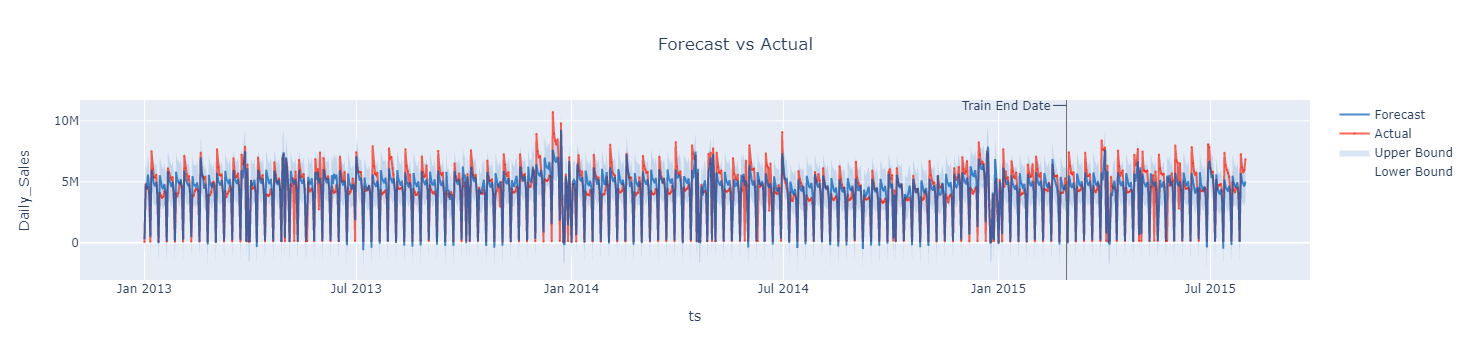

In [58]:
backtest = prophet_result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [59]:
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
    backtest_eval[metric].append(value)
    backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

,train,test
CORR,0.914744,0.880416
R2,0.836756,0.745347
MSE,732068389142.461548,1311501196980.720215
RMSE,855609.951521,1145207.9274
MAE,619166.854294,824761.712982
MedAE,475180.160546,633940.427449
MAPE,56.295009,70.151531
MedAPE,13.385646,15.813395
sMAPE,14.529816,14.587945
Q80,309660.59271,523996.34789


#### Forecast

In [60]:
forecast = prophet_result.forecast
fig = forecast.plot()
plotly.io.show(fig)

#### Model Summary

In [61]:
prophet_result.model[-1]

ProphetEstimator(coverage=0.95, daily_seasonality=False,
                 holidays=           ds                holiday  lower_window  upper_window
0  2016-01-01         New Year's Day            -2             2
1  2016-02-08       Chinese New Year            -2             2
2  2016-04-04      Tomb-Sweeping Day            -2             2
3  2016-04-05      Tomb-Sweeping Day            -2             2
4  2016-05-01              Labor Day            -2             2
..        ...                    ...           ...           ...
47 2015-07-01             Canada Day            -2             2
48 2015-09-07             Labour Day            -2             2
49 2015-10-12           Thanksgiving            -2             2
50 2015-11-11        Remembrance Day            -2             2
52 2015-12-28  Boxing Day (Observed)            -2             2

[130 rows x 4 columns],
                 score_func=<function add_finite_filter_to_scorer.<locals>.score_func_finite at 0x0000015F4F697E